# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier, from loading and inspecting the dataset to training a **pre-trained** Convolutional Neural Network architecture. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Rules and Comments
- From the list of datasets and architectures listed in canvas, each student was atributed **1 dataset and 1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- This is an DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course). Remember that you will have to defend the assignment at the end of the semester.
- **Deadline is March 25**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Viktor Habony**  
**Neptun ID: H8SCMR** 

## Task description
Your task is to train an already pretrained Convolutional Neural Network architecture on a dataset, both given in canvas. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem. 

The dataset shoud be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
# ADD YOUR CODE HERE

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd
import seaborn as sn
import time
import glob
import shutil
import os
import sys
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models


from sklearn import preprocessing
from collections import Counter
from scipy.io import loadmat
from torch.optim import lr_scheduler
from tabulate import tabulate
from statistics import mean
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score,  precision_score, recall_score
%matplotlib inline

## 1. Dataset 
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading the device


In [2]:
# Available CUDA devices
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce RTX 3060


#### Loading the dataset
Show some images and labels of your dataset

In [3]:
# ADD YOUR CODE HERE

# Creating the necessary folders for training and testing
def prepare_images(src_path, dst_path):
    
    labels       = []
    train        = []
    val          = []
    labels       = []
    
    src_dir          = src_path
    dst_dir          = dst_path + '/'
    train_dir        = dst_dir + 'train'
    val_dir          = dst_dir + 'val'
    dest_directories = [train_dir, val_dir]
    
    cars_train_annos = loadmat('devkit/cars_train_annos.mat')
    cars_meta        = loadmat('devkit/cars_meta.mat')

    # Get the classes from meta file (196 class)
    for l in cars_meta['class_names'][0]:
        labels.append(l[0])

    for example in cars_train_annos['annotations'][0]:

        label = labels[example[-2][0][0] - 1] # The class name
        image = example[-1][0] # The image name
        train.append((image,label))

    # Creating subfolders for the classes (training, validation)
    for directory in dest_directories:
        for label in labels:
            if(not os.path.exists(os.path.join(directory, label))):
                os.makedirs(os.path.join(directory, label))
                
    i = 0

    # Copying all images to the train folder    
    for img in train:

        s = shutil.copy(src_dir + '/' + img[0], train_dir + '/' + img[1] + '/')

        if len(s) != 0:
            i += 1
            print("Copying the " + str(i) + ". image to the " + train_dir + '/' + img[1] + " directory")  
        else:
            print("Something went wrong with the " + src_dir + '/' + img[1] + '/' + img[0] + 'image')

    cnt = 0

    # Copying 20% of the images to the validation and test folder
    for subdir in labels:
        for img in os.listdir(train_dir + '/' + subdir):

            length = int(len(os.listdir(train_dir + '/' + subdir)) * 0.2)

            if cnt < length:
                shutil.move(train_dir + '/' + subdir + '/' + img, val_dir + '/' + subdir + '/')
                cnt += 1
        cnt = 0    
    
            
    # Get the number of labels, the images and the images / category
    dataset_classes_size = []
    dataset_sizes        = []
    x                    = [i for i in range(len(labels))]
    y                    = []   
    
    summa = 0

    for directory in dest_directories:
        for subdir in labels:
            
            y.append((subdir, len(os.listdir(directory + '/' + subdir))))
            summa += len(os.listdir(directory + '/' + subdir))
            
        dataset_classes_size.append(y)
        dataset_sizes.append(summa)
        summa = 0
        y     = []

    #y.sort(key=lambda x:x[1])
    
    return x, dataset_classes_size, dataset_sizes


In [4]:
x, dataset_classes_size, dataset_sizes  = prepare_images('cars_train', 'dataset')

Copying the 1. image to the dataset/train/Audi TTS Coupe 2012 directory
Copying the 2. image to the dataset/train/Acura TL Sedan 2012 directory
Copying the 3. image to the dataset/train/Dodge Dakota Club Cab 2007 directory
Copying the 4. image to the dataset/train/Hyundai Sonata Hybrid Sedan 2012 directory
Copying the 5. image to the dataset/train/Ford F-450 Super Duty Crew Cab 2012 directory
Copying the 6. image to the dataset/train/Geo Metro Convertible 1993 directory
Copying the 7. image to the dataset/train/Dodge Journey SUV 2012 directory
Copying the 8. image to the dataset/train/Dodge Charger Sedan 2012 directory
Copying the 9. image to the dataset/train/Mitsubishi Lancer Sedan 2012 directory
Copying the 10. image to the dataset/train/Chevrolet Traverse SUV 2012 directory
Copying the 11. image to the dataset/train/Buick Verano Sedan 2012 directory
Copying the 12. image to the dataset/train/Toyota Sequoia SUV 2012 directory
Copying the 13. image to the dataset/train/Hyundai Elantr

Copying the 265. image to the dataset/train/Chevrolet Corvette Convertible 2012 directory
Copying the 266. image to the dataset/train/Audi 100 Sedan 1994 directory
Copying the 267. image to the dataset/train/Bugatti Veyron 16.4 Coupe 2009 directory
Copying the 268. image to the dataset/train/Chevrolet Silverado 1500 Extended Cab 2012 directory
Copying the 269. image to the dataset/train/Tesla Model S Sedan 2012 directory
Copying the 270. image to the dataset/train/GMC Canyon Extended Cab 2012 directory
Copying the 271. image to the dataset/train/Ram C/V Cargo Van Minivan 2012 directory
Copying the 272. image to the dataset/train/FIAT 500 Convertible 2012 directory
Copying the 273. image to the dataset/train/Chevrolet Silverado 2500HD Regular Cab 2012 directory
Copying the 274. image to the dataset/train/Audi S6 Sedan 2011 directory
Copying the 275. image to the dataset/train/Hyundai Veloster Hatchback 2012 directory
Copying the 276. image to the dataset/train/Hyundai Tucson SUV 2012 di

Copying the 537. image to the dataset/train/Plymouth Neon Coupe 1999 directory
Copying the 538. image to the dataset/train/Ford Mustang Convertible 2007 directory
Copying the 539. image to the dataset/train/Hyundai Elantra Touring Hatchback 2012 directory
Copying the 540. image to the dataset/train/Chevrolet Monte Carlo Coupe 2007 directory
Copying the 541. image to the dataset/train/GMC Canyon Extended Cab 2012 directory
Copying the 542. image to the dataset/train/Dodge Ram Pickup 3500 Crew Cab 2010 directory
Copying the 543. image to the dataset/train/Toyota Sequoia SUV 2012 directory
Copying the 544. image to the dataset/train/Spyker C8 Convertible 2009 directory
Copying the 545. image to the dataset/train/Jeep Liberty SUV 2012 directory
Copying the 546. image to the dataset/train/BMW M3 Coupe 2012 directory
Copying the 547. image to the dataset/train/Buick Regal GS 2012 directory
Copying the 548. image to the dataset/train/Audi A5 Coupe 2012 directory
Copying the 549. image to the 

Copying the 828. image to the dataset/train/Mercedes-Benz SL-Class Coupe 2009 directory
Copying the 829. image to the dataset/train/Chevrolet Sonic Sedan 2012 directory
Copying the 830. image to the dataset/train/Cadillac SRX SUV 2012 directory
Copying the 831. image to the dataset/train/Chevrolet Impala Sedan 2007 directory
Copying the 832. image to the dataset/train/Ford F-150 Regular Cab 2012 directory
Copying the 833. image to the dataset/train/Hyundai Elantra Sedan 2007 directory
Copying the 834. image to the dataset/train/GMC Yukon Hybrid SUV 2012 directory
Copying the 835. image to the dataset/train/Audi S4 Sedan 2007 directory
Copying the 836. image to the dataset/train/Rolls-Royce Phantom Sedan 2012 directory
Copying the 837. image to the dataset/train/Chrysler Town and Country Minivan 2012 directory
Copying the 838. image to the dataset/train/Volvo C30 Hatchback 2012 directory
Copying the 839. image to the dataset/train/Jeep Wrangler SUV 2012 directory
Copying the 840. image 

Copying the 1019. image to the dataset/train/Nissan Leaf Hatchback 2012 directory
Copying the 1020. image to the dataset/train/Dodge Caliber Wagon 2012 directory
Copying the 1021. image to the dataset/train/Mercedes-Benz C-Class Sedan 2012 directory
Copying the 1022. image to the dataset/train/Audi S4 Sedan 2012 directory
Copying the 1023. image to the dataset/train/BMW ActiveHybrid 5 Sedan 2012 directory
Copying the 1024. image to the dataset/train/Land Rover LR2 SUV 2012 directory
Copying the 1025. image to the dataset/train/Honda Accord Sedan 2012 directory
Copying the 1026. image to the dataset/train/Cadillac Escalade EXT Crew Cab 2007 directory
Copying the 1027. image to the dataset/train/Buick Enclave SUV 2012 directory
Copying the 1028. image to the dataset/train/Spyker C8 Coupe 2009 directory
Copying the 1029. image to the dataset/train/Chevrolet Silverado 1500 Classic Extended Cab 2007 directory
Copying the 1030. image to the dataset/train/Isuzu Ascender SUV 2008 directory
Cop

Copying the 1316. image to the dataset/train/Chevrolet Corvette Ron Fellows Edition Z06 2007 directory
Copying the 1317. image to the dataset/train/Volkswagen Beetle Hatchback 2012 directory
Copying the 1318. image to the dataset/train/Chevrolet Malibu Hybrid Sedan 2010 directory
Copying the 1319. image to the dataset/train/Suzuki Aerio Sedan 2007 directory
Copying the 1320. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 1321. image to the dataset/train/Rolls-Royce Phantom Sedan 2012 directory
Copying the 1322. image to the dataset/train/Acura ZDX Hatchback 2012 directory
Copying the 1323. image to the dataset/train/Ford F-150 Regular Cab 2007 directory
Copying the 1324. image to the dataset/train/Bentley Continental Supersports Conv. Convertible 2012 directory
Copying the 1325. image to the dataset/train/Chevrolet Silverado 1500 Classic Extended Cab 2007 directory
Copying the 1326. image to the dataset/train/Chevrolet Malibu Hybrid Sedan 2010 directory
Copying 

Copying the 1588. image to the dataset/train/Ferrari 458 Italia Convertible 2012 directory
Copying the 1589. image to the dataset/train/Audi R8 Coupe 2012 directory
Copying the 1590. image to the dataset/train/Toyota Camry Sedan 2012 directory
Copying the 1591. image to the dataset/train/Audi 100 Wagon 1994 directory
Copying the 1592. image to the dataset/train/Jeep Wrangler SUV 2012 directory
Copying the 1593. image to the dataset/train/BMW Z4 Convertible 2012 directory
Copying the 1594. image to the dataset/train/Suzuki SX4 Hatchback 2012 directory
Copying the 1595. image to the dataset/train/Volvo XC90 SUV 2007 directory
Copying the 1596. image to the dataset/train/Mercedes-Benz SL-Class Coupe 2009 directory
Copying the 1597. image to the dataset/train/GMC Yukon Hybrid SUV 2012 directory
Copying the 1598. image to the dataset/train/Ford Ranger SuperCab 2011 directory
Copying the 1599. image to the dataset/train/Chevrolet Monte Carlo Coupe 2007 directory
Copying the 1600. image to th

Copying the 1887. image to the dataset/train/Ford GT Coupe 2006 directory
Copying the 1888. image to the dataset/train/Chrysler Town and Country Minivan 2012 directory
Copying the 1889. image to the dataset/train/FIAT 500 Convertible 2012 directory
Copying the 1890. image to the dataset/train/BMW ActiveHybrid 5 Sedan 2012 directory
Copying the 1891. image to the dataset/train/Acura RL Sedan 2012 directory
Copying the 1892. image to the dataset/train/BMW X3 SUV 2012 directory
Copying the 1893. image to the dataset/train/GMC Savana Van 2012 directory
Copying the 1894. image to the dataset/train/Hyundai Genesis Sedan 2012 directory
Copying the 1895. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 1896. image to the dataset/train/Land Rover LR2 SUV 2012 directory
Copying the 1897. image to the dataset/train/Ford F-150 Regular Cab 2007 directory
Copying the 1898. image to the dataset/train/Buick Verano Sedan 2012 directory
Copying the 1899. image to the dataset/trai

Copying the 2184. image to the dataset/train/Spyker C8 Coupe 2009 directory
Copying the 2185. image to the dataset/train/Audi S6 Sedan 2011 directory
Copying the 2186. image to the dataset/train/Scion xD Hatchback 2012 directory
Copying the 2187. image to the dataset/train/Isuzu Ascender SUV 2008 directory
Copying the 2188. image to the dataset/train/BMW 3 Series Wagon 2012 directory
Copying the 2189. image to the dataset/train/Mercedes-Benz SL-Class Coupe 2009 directory
Copying the 2190. image to the dataset/train/Plymouth Neon Coupe 1999 directory
Copying the 2191. image to the dataset/train/Lincoln Town Car Sedan 2011 directory
Copying the 2192. image to the dataset/train/Jeep Patriot SUV 2012 directory
Copying the 2193. image to the dataset/train/Ram C/V Cargo Van Minivan 2012 directory
Copying the 2194. image to the dataset/train/Aston Martin V8 Vantage Coupe 2012 directory
Copying the 2195. image to the dataset/train/BMW M3 Coupe 2012 directory
Copying the 2196. image to the data

Copying the 2420. image to the dataset/train/Buick Verano Sedan 2012 directory
Copying the 2421. image to the dataset/train/Mazda Tribute SUV 2011 directory
Copying the 2422. image to the dataset/train/Cadillac CTS-V Sedan 2012 directory
Copying the 2423. image to the dataset/train/Toyota Camry Sedan 2012 directory
Copying the 2424. image to the dataset/train/Volvo C30 Hatchback 2012 directory
Copying the 2425. image to the dataset/train/Land Rover Range Rover SUV 2012 directory
Copying the 2426. image to the dataset/train/BMW M5 Sedan 2010 directory
Copying the 2427. image to the dataset/train/Bugatti Veyron 16.4 Coupe 2009 directory
Copying the 2428. image to the dataset/train/Geo Metro Convertible 1993 directory
Copying the 2429. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 2430. image to the dataset/train/Honda Odyssey Minivan 2012 directory
Copying the 2431. image to the dataset/train/Audi A5 Coupe 2012 directory
Copying the 2432. image to the datase

Copying the 2580. image to the dataset/train/Lamborghini Aventador Coupe 2012 directory
Copying the 2581. image to the dataset/train/Ford Focus Sedan 2007 directory
Copying the 2582. image to the dataset/train/Porsche Panamera Sedan 2012 directory
Copying the 2583. image to the dataset/train/Tesla Model S Sedan 2012 directory
Copying the 2584. image to the dataset/train/Audi RS 4 Convertible 2008 directory
Copying the 2585. image to the dataset/train/Dodge Caliber Wagon 2007 directory
Copying the 2586. image to the dataset/train/Cadillac CTS-V Sedan 2012 directory
Copying the 2587. image to the dataset/train/Rolls-Royce Ghost Sedan 2012 directory
Copying the 2588. image to the dataset/train/Ford F-150 Regular Cab 2007 directory
Copying the 2589. image to the dataset/train/Acura TL Sedan 2012 directory
Copying the 2590. image to the dataset/train/Chevrolet Malibu Hybrid Sedan 2010 directory
Copying the 2591. image to the dataset/train/Ford GT Coupe 2006 directory
Copying the 2592. image

Copying the 2883. image to the dataset/train/Chevrolet Tahoe Hybrid SUV 2012 directory
Copying the 2884. image to the dataset/train/Chevrolet Monte Carlo Coupe 2007 directory
Copying the 2885. image to the dataset/train/Audi RS 4 Convertible 2008 directory
Copying the 2886. image to the dataset/train/Jeep Grand Cherokee SUV 2012 directory
Copying the 2887. image to the dataset/train/Audi 100 Sedan 1994 directory
Copying the 2888. image to the dataset/train/Hyundai Elantra Sedan 2007 directory
Copying the 2889. image to the dataset/train/Bugatti Veyron 16.4 Coupe 2009 directory
Copying the 2890. image to the dataset/train/Nissan Leaf Hatchback 2012 directory
Copying the 2891. image to the dataset/train/Chevrolet Corvette Ron Fellows Edition Z06 2007 directory
Copying the 2892. image to the dataset/train/Bentley Continental GT Coupe 2007 directory
Copying the 2893. image to the dataset/train/Dodge Ram Pickup 3500 Crew Cab 2010 directory
Copying the 2894. image to the dataset/train/Infini

Copying the 3050. image to the dataset/train/Rolls-Royce Ghost Sedan 2012 directory
Copying the 3051. image to the dataset/train/Acura TL Type-S 2008 directory
Copying the 3052. image to the dataset/train/Hyundai Veloster Hatchback 2012 directory
Copying the 3053. image to the dataset/train/Ford GT Coupe 2006 directory
Copying the 3054. image to the dataset/train/Acura TSX Sedan 2012 directory
Copying the 3055. image to the dataset/train/Audi TTS Coupe 2012 directory
Copying the 3056. image to the dataset/train/Dodge Sprinter Cargo Van 2009 directory
Copying the 3057. image to the dataset/train/Audi TT Hatchback 2011 directory
Copying the 3058. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 3059. image to the dataset/train/Volvo XC90 SUV 2007 directory
Copying the 3060. image to the dataset/train/Chevrolet HHR SS 2010 directory
Copying the 3061. image to the dataset/train/Ford F-150 Regular Cab 2007 directory
Copying the 3062. image to the dataset/train/Che

Copying the 3309. image to the dataset/train/GMC Canyon Extended Cab 2012 directory
Copying the 3310. image to the dataset/train/Spyker C8 Convertible 2009 directory
Copying the 3311. image to the dataset/train/Aston Martin V8 Vantage Convertible 2012 directory
Copying the 3312. image to the dataset/train/Ford Ranger SuperCab 2011 directory
Copying the 3313. image to the dataset/train/Audi A5 Coupe 2012 directory
Copying the 3314. image to the dataset/train/Audi V8 Sedan 1994 directory
Copying the 3315. image to the dataset/train/Daewoo Nubira Wagon 2002 directory
Copying the 3316. image to the dataset/train/Acura ZDX Hatchback 2012 directory
Copying the 3317. image to the dataset/train/Acura RL Sedan 2012 directory
Copying the 3318. image to the dataset/train/GMC Savana Van 2012 directory
Copying the 3319. image to the dataset/train/HUMMER H2 SUT Crew Cab 2009 directory
Copying the 3320. image to the dataset/train/Chevrolet Silverado 2500HD Regular Cab 2012 directory
Copying the 3321.

Copying the 3601. image to the dataset/train/Dodge Durango SUV 2012 directory
Copying the 3602. image to the dataset/train/Chevrolet Corvette ZR1 2012 directory
Copying the 3603. image to the dataset/train/Bentley Arnage Sedan 2009 directory
Copying the 3604. image to the dataset/train/Chevrolet TrailBlazer SS 2009 directory
Copying the 3605. image to the dataset/train/Lamborghini Gallardo LP 570-4 Superleggera 2012 directory
Copying the 3606. image to the dataset/train/Chevrolet Corvette Ron Fellows Edition Z06 2007 directory
Copying the 3607. image to the dataset/train/Acura TL Type-S 2008 directory
Copying the 3608. image to the dataset/train/Acura Integra Type R 2001 directory
Copying the 3609. image to the dataset/train/Mercedes-Benz Sprinter Van 2012 directory
Copying the 3610. image to the dataset/train/Dodge Charger Sedan 2012 directory
Copying the 3611. image to the dataset/train/Ram C/V Cargo Van Minivan 2012 directory
Copying the 3612. image to the dataset/train/Chevrolet Si

Copying the 3877. image to the dataset/train/Acura Integra Type R 2001 directory
Copying the 3878. image to the dataset/train/smart fortwo Convertible 2012 directory
Copying the 3879. image to the dataset/train/Cadillac Escalade EXT Crew Cab 2007 directory
Copying the 3880. image to the dataset/train/Volvo C30 Hatchback 2012 directory
Copying the 3881. image to the dataset/train/Acura TL Sedan 2012 directory
Copying the 3882. image to the dataset/train/Aston Martin Virage Coupe 2012 directory
Copying the 3883. image to the dataset/train/Hyundai Veloster Hatchback 2012 directory
Copying the 3884. image to the dataset/train/Suzuki SX4 Hatchback 2012 directory
Copying the 3885. image to the dataset/train/Honda Accord Sedan 2012 directory
Copying the 3886. image to the dataset/train/Audi S4 Sedan 2007 directory
Copying the 3887. image to the dataset/train/Audi S6 Sedan 2011 directory
Copying the 3888. image to the dataset/train/Jeep Grand Cherokee SUV 2012 directory
Copying the 3889. image

Copying the 4183. image to the dataset/train/Nissan Juke Hatchback 2012 directory
Copying the 4184. image to the dataset/train/HUMMER H2 SUT Crew Cab 2009 directory
Copying the 4185. image to the dataset/train/Scion xD Hatchback 2012 directory
Copying the 4186. image to the dataset/train/Aston Martin V8 Vantage Convertible 2012 directory
Copying the 4187. image to the dataset/train/Chevrolet Silverado 1500 Extended Cab 2012 directory
Copying the 4188. image to the dataset/train/GMC Acadia SUV 2012 directory
Copying the 4189. image to the dataset/train/Chevrolet Express Cargo Van 2007 directory
Copying the 4190. image to the dataset/train/Aston Martin Virage Convertible 2012 directory
Copying the 4191. image to the dataset/train/Audi V8 Sedan 1994 directory
Copying the 4192. image to the dataset/train/Ferrari California Convertible 2012 directory
Copying the 4193. image to the dataset/train/Jeep Compass SUV 2012 directory
Copying the 4194. image to the dataset/train/Chrysler Town and Co

Copying the 4475. image to the dataset/train/Audi TT RS Coupe 2012 directory
Copying the 4476. image to the dataset/train/Chevrolet Corvette Ron Fellows Edition Z06 2007 directory
Copying the 4477. image to the dataset/train/Dodge Challenger SRT8 2011 directory
Copying the 4478. image to the dataset/train/Chevrolet Silverado 1500 Hybrid Crew Cab 2012 directory
Copying the 4479. image to the dataset/train/Toyota 4Runner SUV 2012 directory
Copying the 4480. image to the dataset/train/Audi S4 Sedan 2007 directory
Copying the 4481. image to the dataset/train/HUMMER H2 SUT Crew Cab 2009 directory
Copying the 4482. image to the dataset/train/Acura TL Type-S 2008 directory
Copying the 4483. image to the dataset/train/GMC Savana Van 2012 directory
Copying the 4484. image to the dataset/train/Acura TSX Sedan 2012 directory
Copying the 4485. image to the dataset/train/Dodge Charger SRT-8 2009 directory
Copying the 4486. image to the dataset/train/Acura RL Sedan 2012 directory
Copying the 4487. i

Copying the 4778. image to the dataset/train/BMW 6 Series Convertible 2007 directory
Copying the 4779. image to the dataset/train/Bentley Continental Supersports Conv. Convertible 2012 directory
Copying the 4780. image to the dataset/train/Volkswagen Beetle Hatchback 2012 directory
Copying the 4781. image to the dataset/train/MINI Cooper Roadster Convertible 2012 directory
Copying the 4782. image to the dataset/train/BMW Z4 Convertible 2012 directory
Copying the 4783. image to the dataset/train/Bentley Mulsanne Sedan 2011 directory
Copying the 4784. image to the dataset/train/Dodge Durango SUV 2007 directory
Copying the 4785. image to the dataset/train/Ford F-150 Regular Cab 2007 directory
Copying the 4786. image to the dataset/train/Chrysler 300 SRT-8 2010 directory
Copying the 4787. image to the dataset/train/Rolls-Royce Phantom Drophead Coupe Convertible 2012 directory
Copying the 4788. image to the dataset/train/Hyundai Tucson SUV 2012 directory
Copying the 4789. image to the datas

Copying the 4897. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 4898. image to the dataset/train/Chevrolet Silverado 1500 Extended Cab 2012 directory
Copying the 4899. image to the dataset/train/Chevrolet Avalanche Crew Cab 2012 directory
Copying the 4900. image to the dataset/train/Cadillac SRX SUV 2012 directory
Copying the 4901. image to the dataset/train/Jaguar XK XKR 2012 directory
Copying the 4902. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 4903. image to the dataset/train/Dodge Caravan Minivan 1997 directory
Copying the 4904. image to the dataset/train/Maybach Landaulet Convertible 2012 directory
Copying the 4905. image to the dataset/train/Tesla Model S Sedan 2012 directory
Copying the 4906. image to the dataset/train/Ferrari California Convertible 2012 directory
Copying the 4907. image to the dataset/train/Hyundai Sonata Hybrid Sedan 2012 directory
Copying the 4908. image to the dataset/train/Maybach Landaulet Convertib

Copying the 5032. image to the dataset/train/Chevrolet Express Van 2007 directory
Copying the 5033. image to the dataset/train/Cadillac SRX SUV 2012 directory
Copying the 5034. image to the dataset/train/Chevrolet Malibu Hybrid Sedan 2010 directory
Copying the 5035. image to the dataset/train/GMC Savana Van 2012 directory
Copying the 5036. image to the dataset/train/Mercedes-Benz E-Class Sedan 2012 directory
Copying the 5037. image to the dataset/train/Hyundai Veloster Hatchback 2012 directory
Copying the 5038. image to the dataset/train/Ford F-150 Regular Cab 2007 directory
Copying the 5039. image to the dataset/train/Scion xD Hatchback 2012 directory
Copying the 5040. image to the dataset/train/Audi TT RS Coupe 2012 directory
Copying the 5041. image to the dataset/train/Dodge Sprinter Cargo Van 2009 directory
Copying the 5042. image to the dataset/train/Acura Integra Type R 2001 directory
Copying the 5043. image to the dataset/train/Volkswagen Golf Hatchback 2012 directory
Copying th

Copying the 5418. image to the dataset/train/Ram C/V Cargo Van Minivan 2012 directory
Copying the 5419. image to the dataset/train/FIAT 500 Abarth 2012 directory
Copying the 5420. image to the dataset/train/Tesla Model S Sedan 2012 directory
Copying the 5421. image to the dataset/train/Cadillac CTS-V Sedan 2012 directory
Copying the 5422. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 5423. image to the dataset/train/Ferrari FF Coupe 2012 directory
Copying the 5424. image to the dataset/train/Fisker Karma Sedan 2012 directory
Copying the 5425. image to the dataset/train/Audi TT RS Coupe 2012 directory
Copying the 5426. image to the dataset/train/Audi S5 Coupe 2012 directory
Copying the 5427. image to the dataset/train/FIAT 500 Convertible 2012 directory
Copying the 5428. image to the dataset/train/Ford Focus Sedan 2007 directory
Copying the 5429. image to the dataset/train/Audi S4 Sedan 2007 directory
Copying the 5430. image to the dataset/train/Mercedes-Benz SL

Copying the 5699. image to the dataset/train/Bentley Continental GT Coupe 2007 directory
Copying the 5700. image to the dataset/train/Suzuki SX4 Hatchback 2012 directory
Copying the 5701. image to the dataset/train/Cadillac CTS-V Sedan 2012 directory
Copying the 5702. image to the dataset/train/Cadillac Escalade EXT Crew Cab 2007 directory
Copying the 5703. image to the dataset/train/Nissan NV Passenger Van 2012 directory
Copying the 5704. image to the dataset/train/GMC Canyon Extended Cab 2012 directory
Copying the 5705. image to the dataset/train/Audi S6 Sedan 2011 directory
Copying the 5706. image to the dataset/train/BMW M5 Sedan 2010 directory
Copying the 5707. image to the dataset/train/Bentley Continental Flying Spur Sedan 2007 directory
Copying the 5708. image to the dataset/train/Toyota 4Runner SUV 2012 directory
Copying the 5709. image to the dataset/train/FIAT 500 Abarth 2012 directory
Copying the 5710. image to the dataset/train/BMW ActiveHybrid 5 Sedan 2012 directory
Copyi

Copying the 5991. image to the dataset/train/Chevrolet TrailBlazer SS 2009 directory
Copying the 5992. image to the dataset/train/Buick Rainier SUV 2007 directory
Copying the 5993. image to the dataset/train/Chevrolet Sonic Sedan 2012 directory
Copying the 5994. image to the dataset/train/Jeep Patriot SUV 2012 directory
Copying the 5995. image to the dataset/train/Mercedes-Benz 300-Class Convertible 1993 directory
Copying the 5996. image to the dataset/train/Chrysler Sebring Convertible 2010 directory
Copying the 5997. image to the dataset/train/Buick Enclave SUV 2012 directory
Copying the 5998. image to the dataset/train/Nissan Juke Hatchback 2012 directory
Copying the 5999. image to the dataset/train/Mazda Tribute SUV 2011 directory
Copying the 6000. image to the dataset/train/Dodge Ram Pickup 3500 Quad Cab 2009 directory
Copying the 6001. image to the dataset/train/Rolls-Royce Ghost Sedan 2012 directory
Copying the 6002. image to the dataset/train/Aston Martin V8 Vantage Convertible

Copying the 6188. image to the dataset/train/Volkswagen Beetle Hatchback 2012 directory
Copying the 6189. image to the dataset/train/Ford Expedition EL SUV 2009 directory
Copying the 6190. image to the dataset/train/Dodge Charger Sedan 2012 directory
Copying the 6191. image to the dataset/train/Buick Rainier SUV 2007 directory
Copying the 6192. image to the dataset/train/Hyundai Veracruz SUV 2012 directory
Copying the 6193. image to the dataset/train/Audi S5 Coupe 2012 directory
Copying the 6194. image to the dataset/train/Hyundai Veracruz SUV 2012 directory
Copying the 6195. image to the dataset/train/Jeep Wrangler SUV 2012 directory
Copying the 6196. image to the dataset/train/Acura Integra Type R 2001 directory
Copying the 6197. image to the dataset/train/Buick Enclave SUV 2012 directory
Copying the 6198. image to the dataset/train/MINI Cooper Roadster Convertible 2012 directory
Copying the 6199. image to the dataset/train/Cadillac Escalade EXT Crew Cab 2007 directory
Copying the 62

Copying the 6390. image to the dataset/train/Toyota 4Runner SUV 2012 directory
Copying the 6391. image to the dataset/train/Ford GT Coupe 2006 directory
Copying the 6392. image to the dataset/train/Bugatti Veyron 16.4 Convertible 2009 directory
Copying the 6393. image to the dataset/train/Nissan Juke Hatchback 2012 directory
Copying the 6394. image to the dataset/train/Infiniti G Coupe IPL 2012 directory
Copying the 6395. image to the dataset/train/Bentley Continental Supersports Conv. Convertible 2012 directory
Copying the 6396. image to the dataset/train/Chevrolet Silverado 1500 Hybrid Crew Cab 2012 directory
Copying the 6397. image to the dataset/train/Spyker C8 Convertible 2009 directory
Copying the 6398. image to the dataset/train/Honda Odyssey Minivan 2012 directory
Copying the 6399. image to the dataset/train/Mercedes-Benz 300-Class Convertible 1993 directory
Copying the 6400. image to the dataset/train/Isuzu Ascender SUV 2008 directory
Copying the 6401. image to the dataset/tra

Copying the 6576. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 6577. image to the dataset/train/Chevrolet Avalanche Crew Cab 2012 directory
Copying the 6578. image to the dataset/train/HUMMER H2 SUT Crew Cab 2009 directory
Copying the 6579. image to the dataset/train/Chevrolet Express Cargo Van 2007 directory
Copying the 6580. image to the dataset/train/Rolls-Royce Phantom Drophead Coupe Convertible 2012 directory
Copying the 6581. image to the dataset/train/Audi S5 Coupe 2012 directory
Copying the 6582. image to the dataset/train/Honda Accord Sedan 2012 directory
Copying the 6583. image to the dataset/train/Bentley Arnage Sedan 2009 directory
Copying the 6584. image to the dataset/train/GMC Canyon Extended Cab 2012 directory
Copying the 6585. image to the dataset/train/Volkswagen Golf Hatchback 2012 directory
Copying the 6586. image to the dataset/train/Audi TTS Coupe 2012 directory
Copying the 6587. image to the dataset/train/Cadillac Escalade EXT Crew Cab 2

Copying the 6853. image to the dataset/train/GMC Acadia SUV 2012 directory
Copying the 6854. image to the dataset/train/Maybach Landaulet Convertible 2012 directory
Copying the 6855. image to the dataset/train/Jeep Patriot SUV 2012 directory
Copying the 6856. image to the dataset/train/Chevrolet Express Van 2007 directory
Copying the 6857. image to the dataset/train/Audi TTS Coupe 2012 directory
Copying the 6858. image to the dataset/train/Spyker C8 Coupe 2009 directory
Copying the 6859. image to the dataset/train/Audi RS 4 Convertible 2008 directory
Copying the 6860. image to the dataset/train/Bentley Arnage Sedan 2009 directory
Copying the 6861. image to the dataset/train/Mercedes-Benz C-Class Sedan 2012 directory
Copying the 6862. image to the dataset/train/Chevrolet Tahoe Hybrid SUV 2012 directory
Copying the 6863. image to the dataset/train/Buick Enclave SUV 2012 directory
Copying the 6864. image to the dataset/train/Chevrolet Silverado 1500 Regular Cab 2012 directory
Copying the 

Copying the 7136. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 7137. image to the dataset/train/GMC Terrain SUV 2012 directory
Copying the 7138. image to the dataset/train/Chevrolet TrailBlazer SS 2009 directory
Copying the 7139. image to the dataset/train/Chevrolet Express Cargo Van 2007 directory
Copying the 7140. image to the dataset/train/Mercedes-Benz C-Class Sedan 2012 directory
Copying the 7141. image to the dataset/train/McLaren MP4-12C Coupe 2012 directory
Copying the 7142. image to the dataset/train/Audi TT Hatchback 2011 directory
Copying the 7143. image to the dataset/train/Ford F-150 Regular Cab 2007 directory
Copying the 7144. image to the dataset/train/BMW 1 Series Convertible 2012 directory
Copying the 7145. image to the dataset/train/Jeep Compass SUV 2012 directory
Copying the 7146. image to the dataset/train/BMW 3 Series Sedan 2012 directory
Copying the 7147. image to the dataset/train/Volkswagen Beetle Hatchback 2012 directory
Copying the 71

Copying the 7282. image to the dataset/train/Nissan NV Passenger Van 2012 directory
Copying the 7283. image to the dataset/train/Daewoo Nubira Wagon 2002 directory
Copying the 7284. image to the dataset/train/Honda Odyssey Minivan 2007 directory
Copying the 7285. image to the dataset/train/Bentley Mulsanne Sedan 2011 directory
Copying the 7286. image to the dataset/train/BMW M5 Sedan 2010 directory
Copying the 7287. image to the dataset/train/Hyundai Tucson SUV 2012 directory
Copying the 7288. image to the dataset/train/Toyota Sequoia SUV 2012 directory
Copying the 7289. image to the dataset/train/Nissan Leaf Hatchback 2012 directory
Copying the 7290. image to the dataset/train/AM General Hummer SUV 2000 directory
Copying the 7291. image to the dataset/train/FIAT 500 Abarth 2012 directory
Copying the 7292. image to the dataset/train/BMW X6 SUV 2012 directory
Copying the 7293. image to the dataset/train/Jeep Liberty SUV 2012 directory
Copying the 7294. image to the dataset/train/Jeep Wr

Copying the 7495. image to the dataset/train/Bentley Continental Flying Spur Sedan 2007 directory
Copying the 7496. image to the dataset/train/Audi V8 Sedan 1994 directory
Copying the 7497. image to the dataset/train/Chrysler Crossfire Convertible 2008 directory
Copying the 7498. image to the dataset/train/Chevrolet Express Cargo Van 2007 directory
Copying the 7499. image to the dataset/train/Chevrolet HHR SS 2010 directory
Copying the 7500. image to the dataset/train/smart fortwo Convertible 2012 directory
Copying the 7501. image to the dataset/train/BMW ActiveHybrid 5 Sedan 2012 directory
Copying the 7502. image to the dataset/train/Chrysler 300 SRT-8 2010 directory
Copying the 7503. image to the dataset/train/Audi S4 Sedan 2012 directory
Copying the 7504. image to the dataset/train/Jeep Patriot SUV 2012 directory
Copying the 7505. image to the dataset/train/Mercedes-Benz SL-Class Coupe 2009 directory
Copying the 7506. image to the dataset/train/Rolls-Royce Phantom Sedan 2012 directo

Copying the 7632. image to the dataset/train/Isuzu Ascender SUV 2008 directory
Copying the 7633. image to the dataset/train/Volvo 240 Sedan 1993 directory
Copying the 7634. image to the dataset/train/Volkswagen Beetle Hatchback 2012 directory
Copying the 7635. image to the dataset/train/Bugatti Veyron 16.4 Coupe 2009 directory
Copying the 7636. image to the dataset/train/Rolls-Royce Ghost Sedan 2012 directory
Copying the 7637. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 7638. image to the dataset/train/Ford Edge SUV 2012 directory
Copying the 7639. image to the dataset/train/BMW 6 Series Convertible 2007 directory
Copying the 7640. image to the dataset/train/Lamborghini Aventador Coupe 2012 directory
Copying the 7641. image to the dataset/train/Jeep Grand Cherokee SUV 2012 directory
Copying the 7642. image to the dataset/train/Spyker C8 Coupe 2009 directory
Copying the 7643. image to the dataset/train/Chrysler 300 SRT-8 2010 directory
Copying the 7644. image 

Copying the 7755. image to the dataset/train/Honda Accord Sedan 2012 directory
Copying the 7756. image to the dataset/train/Chevrolet Malibu Sedan 2007 directory
Copying the 7757. image to the dataset/train/GMC Yukon Hybrid SUV 2012 directory
Copying the 7758. image to the dataset/train/Maybach Landaulet Convertible 2012 directory
Copying the 7759. image to the dataset/train/BMW M6 Convertible 2010 directory
Copying the 7760. image to the dataset/train/Hyundai Azera Sedan 2012 directory
Copying the 7761. image to the dataset/train/Geo Metro Convertible 1993 directory
Copying the 7762. image to the dataset/train/Dodge Durango SUV 2012 directory
Copying the 7763. image to the dataset/train/Chrysler Sebring Convertible 2010 directory
Copying the 7764. image to the dataset/train/BMW M6 Convertible 2010 directory
Copying the 7765. image to the dataset/train/Audi TTS Coupe 2012 directory
Copying the 7766. image to the dataset/train/Bugatti Veyron 16.4 Coupe 2009 directory
Copying the 7767. i

Copying the 8029. image to the dataset/train/Ford F-450 Super Duty Crew Cab 2012 directory
Copying the 8030. image to the dataset/train/FIAT 500 Abarth 2012 directory
Copying the 8031. image to the dataset/train/AM General Hummer SUV 2000 directory
Copying the 8032. image to the dataset/train/BMW M3 Coupe 2012 directory
Copying the 8033. image to the dataset/train/BMW M6 Convertible 2010 directory
Copying the 8034. image to the dataset/train/Hyundai Sonata Sedan 2012 directory
Copying the 8035. image to the dataset/train/Chevrolet Malibu Sedan 2007 directory
Copying the 8036. image to the dataset/train/Toyota Camry Sedan 2012 directory
Copying the 8037. image to the dataset/train/Chevrolet Express Van 2007 directory
Copying the 8038. image to the dataset/train/Chrysler Crossfire Convertible 2008 directory
Copying the 8039. image to the dataset/train/Jeep Liberty SUV 2012 directory
Copying the 8040. image to the dataset/train/Chevrolet Corvette Ron Fellows Edition Z06 2007 directory
Cop

Training set size : 6839 , Validation set size: 1305
The average images/class in the training set: 34



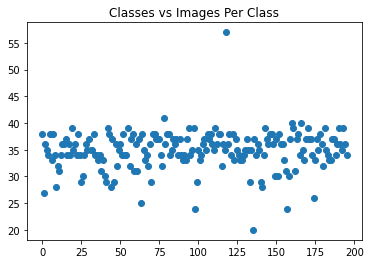

In [5]:
print('Training set size : {} , Validation set size: {}'.format(dataset_sizes[0], dataset_sizes[1]))
avg_image_num = mean(e[1] for e in dataset_classes_size[0])
print('The average images/class in the training set: ' +  str(int(avg_image_num)))
print()

# Plotting the distribution of the images / classes
plt.scatter(x, [e[1] for e in dataset_classes_size[0]])
plt.title('Classes vs Images Per Class')
plt.show() 

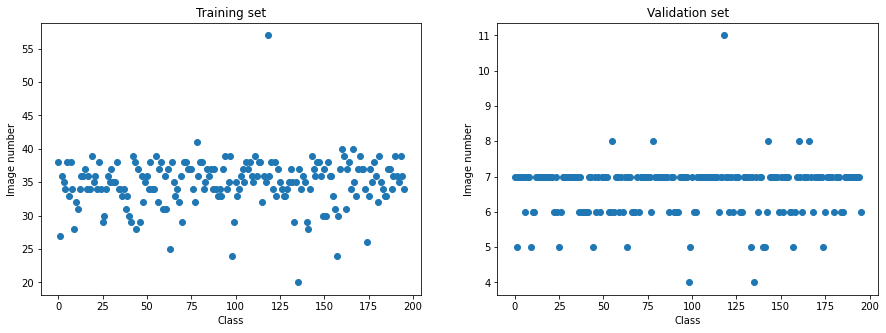

In [6]:
fig, axis = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(15,5)

dirs = ['Training set', 'Validation set']

for i in range(len(dataset_classes_size)):
    
    axis[i].scatter(x, [e[1] for e in dataset_classes_size[i]])
    axis[i].set_title(dirs[i])
    axis[i].set_xlabel('Class')
    axis[i].set_ylabel('Image number')


#### Preprocessing and splitting the dataset

In [7]:
# Function for preprocessing
def preprocess_data(img_size):

    # Transform data to tensor and normalize with mean=0.5 and standard deviation=0.5 for each channel
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            #transforms.RandomResizedCrop(img_size),
            transforms.RandomHorizontalFlip(),
            #transforms.RandomVerticalFlip(),
            #transforms.RandomAffine(degrees=40, scale=(.9, 1.1), shear=0),
            #transforms.RandomPerspective(distortion_scale=0.2),
            #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            #transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        
        'test': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            #transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    
    return data_transforms

# Function for loading the data
def load_data(root_folder, transformers, batch_size):

    # Load training set and apply transformations
    image_datasets            = {x: torchvision.datasets.ImageFolder(os.path.join(root_folder, x), transformers[x]) for x in ['train', 'val']}
    val_dataset, test_dataset = torch.utils.data.random_split(image_datasets['val'], [653, 652])
    image_datasets['val']     = val_dataset
    image_datasets['test']    = test_dataset
    
    dataloaders    = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle = True, num_workers = 1) for x in ['train', 'val', 'test']}
    
    dataset_sizes  = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    class_names    = image_datasets['train'].classes
    
    return image_datasets, dataloaders, dataset_sizes, class_names

# Function for convert an image to tensor
def img_to_tensor(img):
    
    img  = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)
    
    return img

# Displaying image
def imshow(img, figsize, title, fontsize):
    plt.figure(figsize = figsize)
    plt.title(title, fontsize = fontsize)
    plt.imshow(img)

In [8]:
# Preprocessing, loading and displaying the data
transformers                                              = preprocess_data(224)
image_datasets, dataloaders,  dataset_sizes, class_names  = load_data('dataset/', transformers, 32)

In [9]:
print(dataset_sizes)
print(len(class_names))

{'train': 6839, 'val': 653, 'test': 652}
196


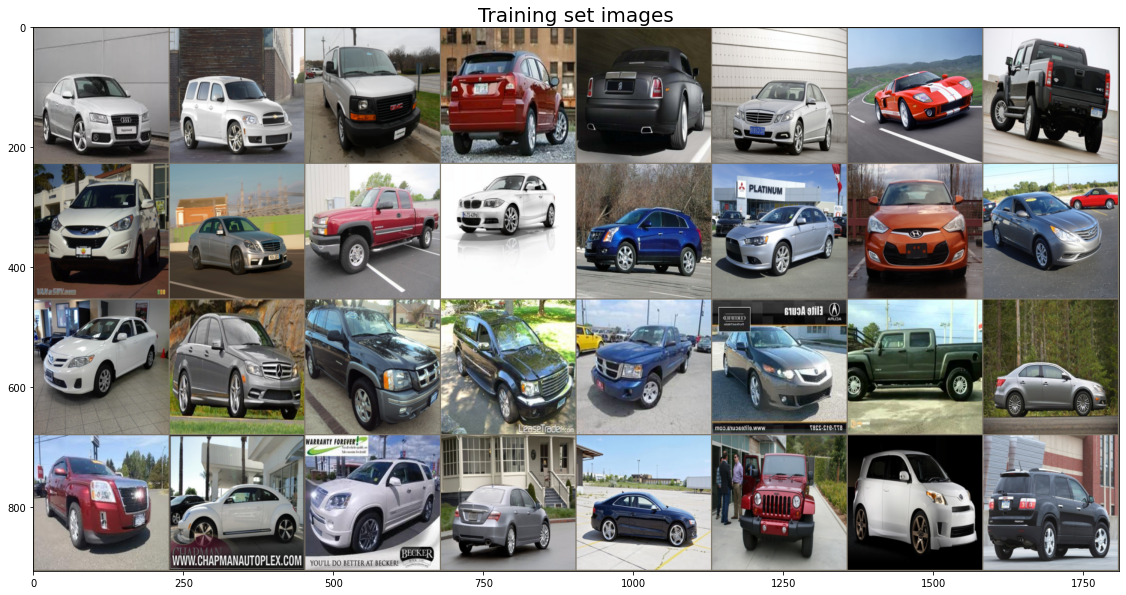

In [10]:
# Get some random training images
dataiter       = iter(dataloaders['train'])
images, labels = dataiter.next()

# Show images
img = img_to_tensor(torchvision.utils.make_grid(images))
imshow(img, (20, 10), 'Training set images', 20)


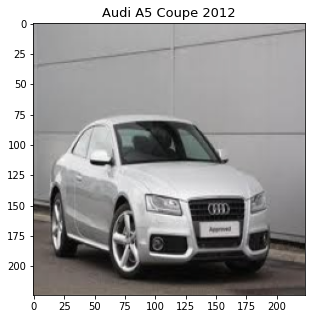

In [11]:
img0 = img_to_tensor(images[0])
imshow(img0, (10,5), class_names[labels[0]], 13)

## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Class for early stopping

In [12]:
class EarlyStopping():
    
    def __init__(self, model, model_name, patience = 3, min_delta = 0):
        
        self.model      = model
        self.best_model = model_name
        self.patience   = patience
        self.min_delta  = min_delta
        self.counter    = 0
        self.best_loss  = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.best_loss = val_loss
            self.counter   = 0
            torch.save(self.model.state_dict(),self.best_model)
        elif self.best_loss - val_loss >= self.min_delta:
            self.counter += 1
            print(f'INFO: Early stopping counter {self.counter} of {self.patience}')
            
            if self.counter >= self.patience:
                print('INFO: Early stopping!') 
                self.early_stop = True

#### Functions for training process
 - train_model: Training the given model with the given parameters
 - evaluate_model: Evaluate the given model on the test set

In [13]:
def train_model(model, criterion, optimizer, scheduler, early_stopping,  num_epochs = 10):
    
    since = time.time()

    losses     = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc       = 0.0

    for epoch in range(num_epochs):
            
        print('Epoch {}/{} LR {:.6f}'.format(epoch + 1, num_epochs, scheduler.get_last_lr()[0]))
        print('-' * 10)

        epoch_start = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss     = 0.0
            running_corrects = 0

            # Iterate over data (mini-batches).
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs  = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss     = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss     += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects.double() / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
       
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
            if phase == 'val':
                early_stopping(epoch_acc)

            
            if early_stopping.early_stop:
                return model, losses, accuracies

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            epoch_end = time.time()    

        print()
        print(str(epoch + 1) +  '. epoch complete in {:.0f}m {:.0f}s'.format( (epoch_end - epoch_start) // 60, (epoch_end - epoch_start) % 60))

    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies


def evaluate_model(model):

    correct_pred   = {classname: 0 for classname in class_names}
    total_pred     = {classname: 0 for classname in class_names}
    class_acc      = []
    correct_labels = []
    acc_per_class  = []
    y_true         = []
    y_pred         = []
    total          = 0
    correct        = 0


    was_training = model.training
    model.eval()

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(dataloaders['test']):

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_pred.extend(preds.data.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())

            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[class_names [label] ] += 1
                    correct_labels.append(label)
                total_pred[class_names [label] ] += 1

            total += labels.size(0)
            correct += (preds == labels).sum().item()  
            
        model.train(mode=was_training)
            
    # Calculate the accuracy for each class
    for classname, correct_count in correct_pred.items():
        
        if total_pred[classname] != 0:
            accuracy = int(100 * float(correct_count) / total_pred[classname])
        else:
            accuracy = 0
        acc_per_class.append(accuracy)
        class_acc.append((classname, accuracy))

    return y_true, y_pred, correct_labels, acc_per_class, class_acc, total, correct
  

#### Functions for training, prediction and statistics visualization
 - visualize_model: Display the given number of images with the correct and predicted label
 - visualize_training: Display the training and validation accuracies and losses
 - visualize_statistics: Display metrics from training and validation (accuracy, recall, precision, balanced accuracy)
 - visualize_classes: Display each class with the corresponding accuracy in table format

In [14]:
def visualize_model(model, fig_size, num_images = 4):
    
    was_training = model.training
    model.eval()
    
    images_so_far = 0

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(dataloaders['test']):

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            tot = num_images
            cols = 5

            # Compute Rows required
            rows = tot // cols 
            rows += tot % cols

            # Create a Position index and a figure
            position = range(1,tot + 1)
            fig = plt.figure(1, figsize = (20, 20))

            for j, (label, prediction) in enumerate(zip(labels, preds)):
                
                # add every single subplot to the figure with a for loop
                img = img_to_tensor(inputs.cpu().data[j])

                ax = fig.add_subplot(rows, cols, position[j])
                ax.set_title('predicted: {} actual: {}'.format(prediction, label))
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.imshow(img) 
                
                images_so_far += 1

                if images_so_far == num_images:

                    model.train(mode=was_training)
                    return

        model.train(mode=was_training) 
        
def visualize_training(accuracies, losses, fname_1, fname_2):
    
    plt.figure(figsize=(10, 7))

    plt.plot([x.item() for x in accuracies['train']], color = 'green', label = 'train accuracy')
    plt.plot([x.item() for x in accuracies['val']],   color = 'blue',  label = 'validation accuracy')
    plt.legend()
    plt.savefig(fname_1)
    plt.show()

    plt.figure(figsize=(10, 7))

    plt.plot(losses['train'], color = 'orange', label = 'train loss')
    plt.plot(losses['val'],   color = 'red',    label = 'validation loss')
    plt.legend()
    plt.savefig(fname_2)
    plt.show()
    
def visualize_statistics(y_true, y_pred):
    
    # Statistics and metrics

    accuracy          = accuracy_score(y_true, y_pred)
    recall            = recall_score(y_true, y_pred, average = 'macro')
    precision         = precision_score(y_true, y_pred, average = 'macro')
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)


    print(classification_report(y_true, y_pred))
    print()
    print("Accuracy of the total model is {:.2f}".format(accuracy * 100) + '%')
    print("Recall of the total model is {:.2f}".format(recall * 100) + '%')
    print("Precision of the total model is {:.2f}".format(precision * 100) + '%')
    print("Balanced accuracy of the total model is {:.2f}".format(balanced_accuracy * 100) + '%')
    
def visualize_classes(total, correct, class_acc):
    
    col_names = ['Class', 'Accuracy']

    print('Accuracy of the network on ' + str(total) + ' test images: %d %%' % (100 * correct / total))
    print()
    print()

    class_acc.sort(key = lambda x:x[1], reverse = True)
    c = dict(Counter([x[1] for x in class_acc]))

    print(tabulate(class_acc, headers = col_names, tablefmt = "fancy_grid"))
    print()
    print(c)
    
    class_sum = 0
    
    for (key, value) in c.items():
        
        if key >= 50:
            class_sum += value
    print()
    print('There were 196/' + str(class_sum) + ' classes whose accuracies were better than 50%.')
    
    

#### Load the architecture

## 2.1 Pretrained, frozen model
With this approach, we got poor accuracy and flat training curve because in this case, the model is underfitting. One of the problems could be that is VGG16 was trained on the ImageNet database, and our Stanford Cars database differs from that. In this case, we changed the last Dense layer output only. In this case we got:
 - Accuracy of the total model is 26.07%
 - Recall of the total model is 26.73%
 - Precision of the total model is 25.21%
 - Balanced accuracy of the total model is 26.73%
 
There were 196/52 classes whose accuracies were better than 50%.

In [15]:
model_frozen = models.vgg16(pretrained=True)

for param in model_frozen.parameters():
    param.requires_grad = False

num_ftrs = model_frozen.classifier[6].in_features

model_frozen.classifier[6] = nn.Linear(num_ftrs, 196)
model_frozen = model_frozen.to(device)

pytorch_total_params = sum(p.numel() for p in model_frozen.parameters() if p.requires_grad)
print(model_frozen)
print(pytorch_total_params)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Define your optimizer and loss function

In [16]:
criterion_frozen        = nn.CrossEntropyLoss()
optimizer_frozen        = optim.SGD(model_frozen.classifier.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler_frozen = lr_scheduler.StepLR(optimizer_frozen, step_size = 4, gamma = 0.1)

# Early stopping
early_stopping = EarlyStopping(model_frozen, 'model_frozen.pth', 2)

#### Train your network

In [17]:
model_frozen, losses_frozen, accuracies_frozen = train_model(model_frozen,
                                                                criterion_frozen,
                                                                optimizer_frozen,
                                                                exp_lr_scheduler_frozen,
                                                                early_stopping,
                                                                num_epochs = 20)

Epoch 1/20 LR 0.001000
----------
train Loss: 4.9300 Acc: 0.0387
val Loss: 4.4431 Acc: 0.0934

1. epoch complete in 0m 49s
Epoch 2/20 LR 0.001000
----------
train Loss: 4.2013 Acc: 0.1179
val Loss: 4.0416 Acc: 0.1547

2. epoch complete in 0m 51s
Epoch 3/20 LR 0.001000
----------
train Loss: 3.8122 Acc: 0.1733
val Loss: 3.7887 Acc: 0.1807

3. epoch complete in 0m 49s
Epoch 4/20 LR 0.001000
----------
train Loss: 3.5408 Acc: 0.2163
val Loss: 3.6122 Acc: 0.2129

4. epoch complete in 0m 49s
Epoch 5/20 LR 0.000100
----------
train Loss: 3.3430 Acc: 0.2705
val Loss: 3.5749 Acc: 0.2266

5. epoch complete in 0m 49s
Epoch 6/20 LR 0.000100
----------
train Loss: 3.3239 Acc: 0.2723
val Loss: 3.5545 Acc: 0.2282

6. epoch complete in 0m 54s
Epoch 7/20 LR 0.000100
----------
train Loss: 3.3080 Acc: 0.2740
val Loss: 3.5401 Acc: 0.2266
INFO: Early stopping counter 1 of 2

7. epoch complete in 0m 45s
Epoch 8/20 LR 0.000100
----------
train Loss: 3.2888 Acc: 0.2777
val Loss: 3.5264 Acc: 0.2297

8. epoch

#### Show results (accuracy and loss) on training and validation sets

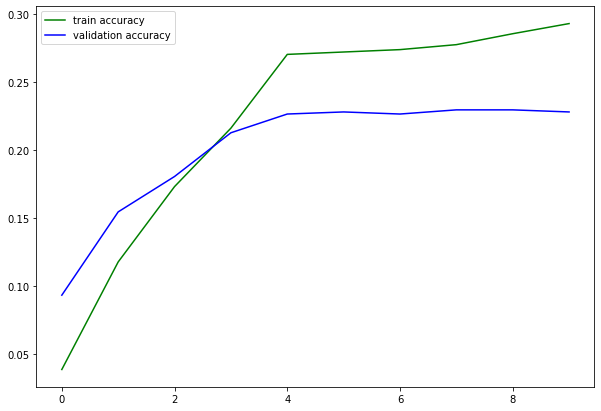

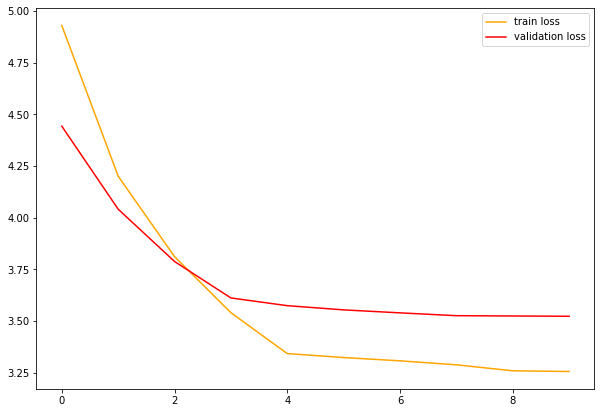

In [18]:
visualize_training(accuracies_frozen, losses_frozen, 'accuracies_frozen.png', 'losses_frozen.png')

#### Save the model

In [19]:
torch.save(model_frozen.state_dict(), 'model_frozen_new.pth')

#### Evaluate your model

In [20]:
y_true_frozen, y_pred_frozen, correct_labels_frozen, acc_per_class_frozen, class_acc_frozen, total_frozen, correct_frozen = evaluate_model(model_frozen)

In [21]:
visualize_statistics(y_true_frozen, y_pred_frozen)

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.25      0.33      0.29         3
           6       0.33      0.25      0.29         4
           7       0.00      0.00      0.00         7
           8       1.00      0.50      0.67         4
           9       0.00      0.00      0.00         2
          10       0.33      0.50      0.40         2
          11       0.00      0.00      0.00         1
          12       0.50      0.33      0.40         3
          13       0.50      0.33      0.40         3
          14       1.00      0.20      0.33         5
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         1
          17       1.00    

c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

In [22]:
visualize_classes(total_frozen, correct_frozen, class_acc_frozen)

Accuracy of the network on 652 test images: 26 %


╒════════════════════════════════════════════════════════╤════════════╕
│ Class                                                  │   Accuracy │
╞════════════════════════════════════════════════════════╪════════════╡
│ AM General Hummer SUV 2000                             │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ BMW 3 Series Wagon 2012                                │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ BMW M6 Convertible 2010                                │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Buick Verano Sedan 2012                                │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Chevrolet HHR SS 2010                                  │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Chrysler To

## 2.2 Pretrained model with unfrozen CNN layers
With this approach, we got high training and validation accuracy and small training and validation losses. This is a necessary step because without that the model would not able to generalize well. The approach is the following:
 - Freeze the first 19 layers
 - Retrain the remaining layers 
 - Change the last classifier (Dense) layer 
 
We used SGD optimizer with a relatively large learning rate for fast training purposes and dynamically reduced the learning rate (every fourth epoch). We used the early stopping technique in order to avoid overfitting. In this case we got:

 - Accuracy of the total model is 72.55%
 - Recall of the total model is 71.43%
 - Precision of the total model is 71.89%
 - Balanced accuracy of the total model is 71.80%
 
There were 196/168 classes whose accuracies were better than 50%.


In [23]:
# ADD YOUR CODE HERE

vgg16 = models.vgg16(pretrained=True)

for param in vgg16.parameters():
    param.requires_grad = False

for param in vgg16.features[19:].parameters():
    param.requires_grad = True

num_ftrs            = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 196)
vgg16               = vgg16.to(device)

#### Define your optimizer and loss function

In [24]:
# ADD YOUR CODE HERE

criterion_vgg16        = nn.CrossEntropyLoss()
optimizer_vgg16        = optim.SGD(vgg16.parameters(), lr = 0.01, momentum = 0.9)
exp_lr_scheduler_vgg16 = lr_scheduler.StepLR(optimizer_vgg16, step_size = 4, gamma = 0.1)

# Early stopping

early_stopping_vgg16 = EarlyStopping(vgg16, 'model_vgg16.pth', 3)

In [25]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
torch.cuda.memory_stats(device=None)

OrderedDict([('active.all.allocated', 139070),
             ('active.all.current', 109),
             ('active.all.freed', 138961),
             ('active.all.peak', 124),
             ('active.large_pool.allocated', 89988),
             ('active.large_pool.current', 26),
             ('active.large_pool.freed', 89962),
             ('active.large_pool.peak', 39),
             ('active.small_pool.allocated', 49082),
             ('active.small_pool.current', 83),
             ('active.small_pool.freed', 48999),
             ('active.small_pool.peak', 85),
             ('active_bytes.all.allocated', 9372728407040),
             ('active_bytes.all.current', 1088594432),
             ('active_bytes.all.freed', 9371639812608),
             ('active_bytes.all.peak', 2341347328),
             ('active_bytes.large_pool.allocated', 9366467947520),
             ('active_bytes.large_pool.current', 1086390272),
             ('active_bytes.large_pool.freed', 9365381557248),
             ('active_by

#### Train your network

In [26]:
vgg16, losses, accuracies = train_model(vgg16,
                                        criterion_vgg16,
                                        optimizer_vgg16,
                                        exp_lr_scheduler_vgg16,
                                        early_stopping_vgg16,
                                        num_epochs = 20)

Epoch 1/20 LR 0.010000
----------
train Loss: 4.8720 Acc: 0.0325
val Loss: 3.9756 Acc: 0.1118

1. epoch complete in 0m 48s
Epoch 2/20 LR 0.010000
----------
train Loss: 3.5320 Acc: 0.1708
val Loss: 2.8168 Acc: 0.2802

2. epoch complete in 0m 52s
Epoch 3/20 LR 0.010000
----------
train Loss: 2.6598 Acc: 0.3183
val Loss: 2.2700 Acc: 0.3890

3. epoch complete in 0m 50s
Epoch 4/20 LR 0.010000
----------
train Loss: 2.0007 Acc: 0.4588
val Loss: 1.8773 Acc: 0.4962

4. epoch complete in 0m 51s
Epoch 5/20 LR 0.001000
----------
train Loss: 0.9522 Acc: 0.7133
val Loss: 1.1657 Acc: 0.6815

5. epoch complete in 0m 49s
Epoch 6/20 LR 0.001000
----------
train Loss: 0.6538 Acc: 0.7995
val Loss: 1.0746 Acc: 0.6922

6. epoch complete in 0m 50s
Epoch 7/20 LR 0.001000
----------
train Loss: 0.5419 Acc: 0.8282
val Loss: 1.0418 Acc: 0.6937

7. epoch complete in 0m 52s
Epoch 8/20 LR 0.001000
----------
train Loss: 0.4480 Acc: 0.8592
val Loss: 1.0532 Acc: 0.7136

8. epoch complete in 0m 51s
Epoch 9/20 LR 0.

#### Show results (accuracy and loss) on training and validation sets

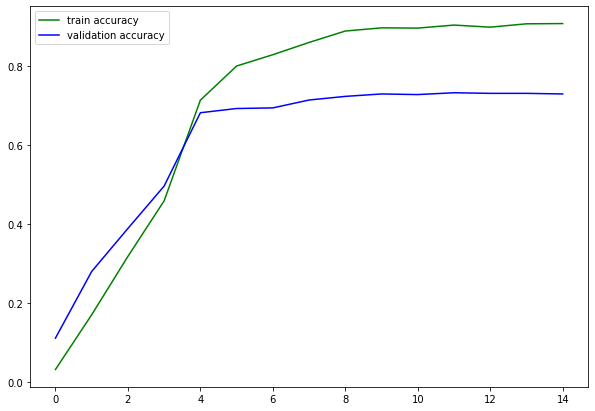

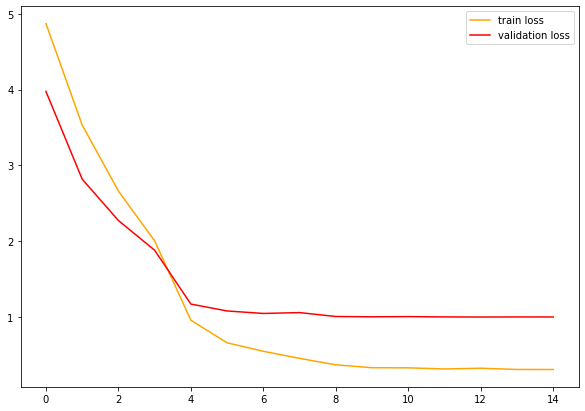

In [27]:
# ADD YOUR CODE HERE

visualize_training(accuracies, losses, 'accuracies.png', 'losses.png')

#### Save the model

In [28]:
torch.save(vgg16.state_dict(), 'vgg16_model_new.pth')

## 3. Conclusion (Evaluation)
Load your trained CNN and evaluate it on the test set. Show some predictions on the test set (3 is enough) by ploting the image and printing the prediction and ground truth.

How good are your results? Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

#### Evaluate your model

In [29]:
# ADD YOUR CODE HERE

y_true, y_pred, correct_labels, acc_per_class, class_acc, total, correct = evaluate_model(vgg16)

In [30]:
# Statistics and metrics

visualize_statistics(y_true, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.50      0.67         4
           2       0.50      1.00      0.67         2
           3       0.67      0.67      0.67         3
           4       1.00      1.00      1.00         1
           5       0.50      0.33      0.40         3
           6       0.75      0.75      0.75         4
           7       0.67      0.57      0.62         7
           8       1.00      1.00      1.00         4
           9       0.00      0.00      0.00         2
          10       1.00      0.50      0.67         2
          11       0.00      0.00      0.00         1
          12       0.33      0.33      0.33         3
          13       0.25      0.67      0.36         3
          14       1.00      1.00      1.00         5
          15       0.67      0.67      0.67         3
          16       0.00      0.00      0.00         1
          17       0.67    

c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMet

In [31]:
# Visualize classes and accuracies

visualize_classes(total, correct, class_acc)

Accuracy of the network on 652 test images: 72 %


╒════════════════════════════════════════════════════════╤════════════╕
│ Class                                                  │   Accuracy │
╞════════════════════════════════════════════════════════╪════════════╡
│ AM General Hummer SUV 2000                             │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Acura RL Sedan 2012                                    │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Acura TL Type-S 2008                                   │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Aston Martin V8 Vantage Coupe 2012                     │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Audi R8 Coupe 2012                                     │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Audi S6 Sed

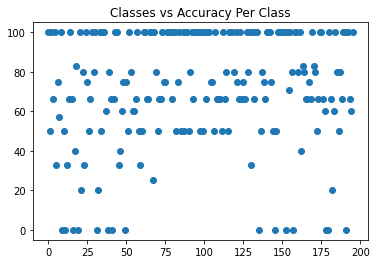

In [32]:
# Plotting the accuracy of the classes
plt.scatter([x for x in range(196)], acc_per_class)
plt.title('Classes vs Accuracy Per Class')
plt.show() 

#### Show some predictions

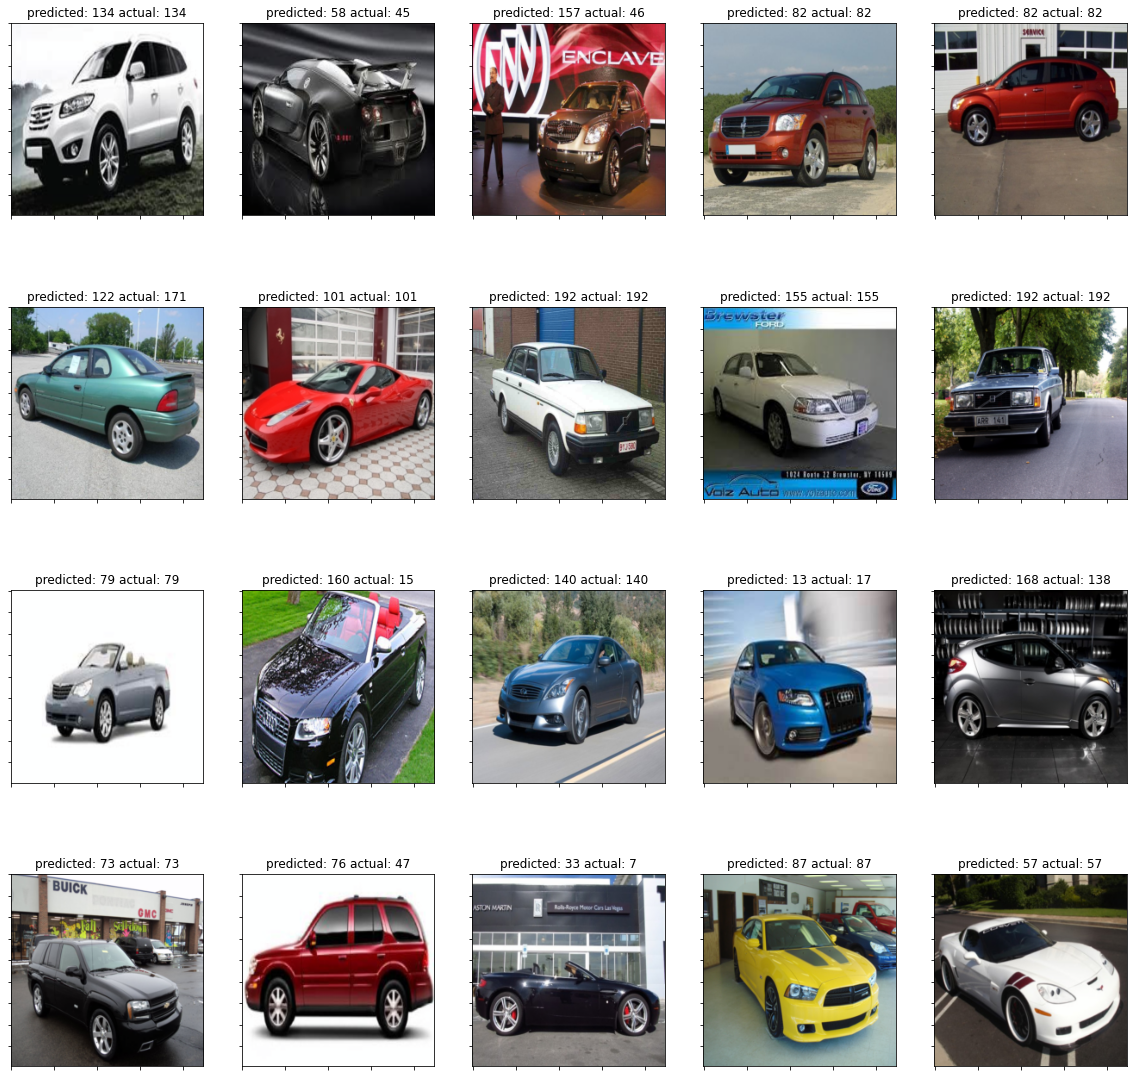

In [33]:
# ADD YOUR CODE HERE

visualize_model(vgg16, (10, 5), 20)

#### Convert to HTML format

In [35]:
os.system('jupyter nbconvert --to html Cars_classification_VGG16.ipynb')

0

#### Answer the questions

How good are your results? 

We have approximately 26% accuracy with the frozen model and 73% accuracy with the Fine-tuned unfrozen model.

Do you think the network is overfitted or underfitted? 

With the frozen model it's clearly underfitted because VGG16 was trained on the ImageNet database, and our Stanford Cars database differs from that. The unfrozen model is little bit overfitted.